In [1]:
# Imports
from __future__ import print_function

# In-repo files
from utils import prepare_vocab_continous as vocab_master
from utils import embeddings_interface as ei
import data_loader as dl
import components as com
import auxiliary as aux
import network as net

# Torch files
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import  DataLoader

# Other libs
from qelos_core.scripts.lcquad.corerank import FlatEncoder
import matplotlib.pyplot as plt
import ConfigParser
import numpy as np
import pylab
import time
import json
import os

device = torch.device("cuda")
np.random.seed(42)
torch.manual_seed(42)

Using TensorFlow backend.


In [2]:
# Important Macros

# Reading and setting up config parser
config = ConfigParser.ConfigParser()
config.readfp(open('configs/intent.cfg'))

# Setting up device,model name and loss types.
training_model = 'bilstm_dense'
_dataset = 'lcquad'
pointwise = False

#Loading relations file.
COMMON_DATA_DIR = 'data/data/common'
_dataset_specific_data_dir = 'data/data/%(dataset)s/' % {'dataset': _dataset}
_word_to_id = aux.load_word_list(COMMON_DATA_DIR)


In [3]:
# Fixing parameters

parameter_dict = {}
parameter_dict['max_length'] =  int(config.get(training_model,'max_length'))
parameter_dict['hidden_size'] = int(config.get(training_model,'hidden_size'))
parameter_dict['number_of_layer'] = int(config.get(training_model,'number_of_layer'))
parameter_dict['embedding_dim'] = int(config.get(training_model,'embedding_dim'))
parameter_dict['vocab_size'] = int(config.get(training_model,'vocab_size'))
parameter_dict['batch_size'] = int(config.get(training_model,'batch_size'))
parameter_dict['bidirectional'] = bool(config.get(training_model,'bidirectional'))
parameter_dict['_neg_paths_per_epoch_train'] = int(config.get(training_model,'_neg_paths_per_epoch_train'))
parameter_dict['_neg_paths_per_epoch_validation'] = int(config.get(training_model,'_neg_paths_per_epoch_validation'))
parameter_dict['total_negative_samples'] = int(config.get(training_model,'total_negative_samples'))
parameter_dict['epochs'] = int(config.get(training_model,'epochs'))
parameter_dict['dropout'] = float(config.get(training_model,'dropout'))

_dataset_specific_data_dir,\
    _model_specific_data_dir,\
    _file,\
    _max_sequence_length,\
    _neg_paths_per_epoch_train,\
    _neg_paths_per_epoch_validation,\
    _training_split,\
    _validation_split,\
    _index = aux.data_loading_parameters(_dataset,parameter_dict)

parameter_dict['index'] = _index
parameter_dict['training_split'] = _training_split
parameter_dict['validation_split'] = _validation_split
parameter_dict['dataset'] = _dataset

In [4]:
# Pull raw data from disk

dataset = json.load(open(os.path.join(_dataset_specific_data_dir, _file)))
vocab, _ = vocab_master.load()

In [5]:
def get_x(_datum):
    return np.asarray(_datum['uri']['question-id'])

def get_y(_datum):
    """
        Legend: 010: ask
                100: count
                001: list
    """

    data = _datum['parsed-data']['sparql_query'][:_datum['parsed-data']['sparql_query'].lower().find('{')]
    # Check for ask
    if u'ask' in data.lower():
        return np.asarray([0, 1, 0])

    if u'count' in data.lower():
        return np.asarray([1, 0, 0])

    return np.asarray([0, 0, 1])

def convert_to_continous_ids(X, vocab):
    """
        Maps the IDs in X to their values in vocab. 
        The vectors and vocab are expected to come via vocab_master file
    """
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j] = vocab[X[i][j]]
    
    return X

def preprocess_data(dataset, vocab, parameter_dict):
    """
        Process the raw data to make X, Y
        Convert them to the new (continous) ID space
        Pad BUT DO NOT SHUFFLE!
        
        Challenge: how do we keep this synced with released splits?
    """
    
    X = np.zeros((len(dataset), parameter_dict['max_length']), dtype=np.int64)
    Y = np.zeros((len(dataset), 3), dtype=np.int64)
    
    for i in range(len(dataset)):
        
        datum = dataset[i]
        
        # Call fns to parse it
        x, y = get_x(datum), get_y(datum)

        # Append ze data into their lists
        X[i, :min(x.shape[0], parameter_dict['max_length'])] = x[:min(x.shape[0], parameter_dict['max_length'])]
        Y[i] = y
        
    # Convert them to new IDs
    X = convert_to_continous_ids(X, vocab)

    # Split
    if parameter_dict['index'] == None:
        # We don't have a specific index, so we split based on split points.

        train_X = X[:int(X.shape[0]*parameter_dict['training_split'])]
        train_Y = Y[:int(Y.shape[0]*parameter_dict['training_split'])]

        valid_X = X[int(X.shape[0]*parameter_dict['training_split']): int(X.shape[0]*parameter_dict['validation_split'])]
        valid_Y = Y[int(Y.shape[0]*parameter_dict['training_split']): int(Y.shape[0]*parameter_dict['validation_split'])]
        
        test_X = X[int(X.shape[0]*parameter_dict['validation_split']): ]
        test_Y = Y[int(Y.shape[0]*parameter_dict['validation_split']): ]
    
        return {'train_X':train_X, 'train_Y':train_Y, \
                'valid_X':valid_X, 'valid_Y':valid_Y, \
                'test_X':test_X, 'test_Y':test_Y }
    
    else:
        
        # We have an index to split with. We first get the test split out by index, 
        # and then we split the rest based on training_split

#         test_X = X[int(X.shape[0]*parameter_dict['index']): ]
#         test_Y = Y[int(Y.shape[0]*parameter_dict['index']): ]
        
#         rest_X = X[ :int(X.shape[0]*parameter_dict['index'])]
#         rest_Y = Y[ :int(Y.shape[0]*parameter_dict['index']): ]
        
        train_X = X[:parameter_dict['index']]
        train_Y = Y[:parameter_dict['index']]
        
        valid_X = X[parameter_dict['index']:]
        valid_Y = Y[parameter_dict['index']:]
        
        return {'train_X':train_X, 'train_Y':train_Y, \
                'valid_X':valid_X, 'valid_Y':valid_Y, \
                'test_X':None, 'test_Y':None }

In [6]:
class IntentClassifier:
    
    def __init__(self, _parameter_dict, _word_to_id,  _device, _pointwise=False, _debug=False):
        self.debug = _debug
        self.parameter_dict = _parameter_dict
        self.device = _device
        self.pointwise = _pointwise
        self.word_to_id = _word_to_id
        self.hiddendim = self.parameter_dict['hidden_size'] * (2 * int(self.parameter_dict['bidirectional']))

        if self.debug:
            print("Init Models")

        self.encoder = FlatEncoder(embdim=self.parameter_dict['embedding_dim'],
                                   dims=[self.parameter_dict['hidden_size']],
                                   word_dic=self.word_to_id,
                                   bidir=True).to(self.device)

        self.dense = com.DenseClf(inputdim=self.hiddendim,        # *2 because we have two things concatinated here
                                  hiddendim=self.hiddendim/2,
                                  outputdim=3).to(self.device)
        
    def train_batch(self, data, optimizer, loss_fn, device):
        '''
            Given data, passes it through model, inited in constructor, returns loss and updates the weight
            :params data: {batch of question, pos paths, neg paths and dummy y labels}
            :params optimizer: torch.optim object
            :params loss fn: torch.nn loss object
            :params device: torch.device object

            returns loss
        '''
        optimizer.zero_grad()
        
        # Unpacking the data and model from args
        ques_batch, y_label = data['ques_batch'], data['y_label']
        
        ques_batch = torch.tensor(ques_batch, dtype=torch.long, device=device)
        y_label = torch.tensor(y_label, dtype=torch.float, device=device)
        
        # Encoding all the data
        ques_batch = self.encoder(ques_batch)

        # Calculating dot score
        out = self.dense(ques_batch)

        '''
            If `y == 1` then it assumed the first input should be ranked higher
            (have a larger value) than the second input, and vice-versa for `y == -1`
        '''
        loss = loss_fn(out, y_label)
        loss.backward()
        optimizer.step()

        return out, loss
    
    
    def predict(self, data, loss_fn, device):
        
        with torch.no_grad():
            
            ques_batch, y_label = data['ques_batch'], data['y_label']
            
            ques_batch = torch.tensor(ques_batch, dtype=torch.long, device=device)
            y_label = torch.tensor(y_label, dtype=torch.float, device=device)
            
            # Encoding all the data
            ques_batch = self.encoder(ques_batch)

            # Calculating dot score
            out = self.dense(ques_batch)

            '''
                If `y == 1` then it assumed the first input should be ranked higher
                (have a larger value) than the second input, and vice-versa for `y == -1`
            '''
            loss = loss_fn(out, y_label)
            
            return out, loss
        
    def eval(self, y_true, y_pred):
        
        return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred.detach().cpu().numpy(), axis=1))
    
    def prepare_save(self):
        
        return [('encoder', self.encoder), ('dense', self.dense)]

In [7]:
def training_loop(classifier, optimizer, loss_fn, dataset, parameter_dict, device):
    
    training_acc = []
    valid_acc = []
    training_loss = []
    best_valid_acc = 0.0
    loc = aux.save_location('intent', 'bilstm_dense', 'lcquad')

    for epoch in range(parameter_dict['epochs']):
        
        epoch_time = time.time()
                
        epoch_loss = []
        epoch_train_acc = []
        
        for b in range(dataset['len']/int(parameter_dict['batch_size'])):
            
            batch_time = time.time()
            
            # Sample new data
            data = {}
            index = np.random.randint(0, dataset['len'], parameter_dict['batch_size'])
            
            data['ques_batch'] = dataset['train_X'][index]
            data['y_label'] = dataset['train_Y'][index]
            
            y_pred, loss = classifier.train_batch(data, optimizer, loss_fn, device)
            
            acc = classifier.eval(y_true = data['y_label'], y_pred = y_pred)
            
            # Book-keeping
            epoch_loss.append(loss.item())
            epoch_train_acc.append(acc)
            
#             print("Batch:\t%d" % b, "/%d\t: " % (dataset['len']/int(parameter_dict['batch_size'])),
#                   "%s" % (time.time() - batch_time),
#                   "\t%s" % (time.time() - epoch_time),
#                   "\tloss: %s" % loss.item(),
#                   end=None if b + 1 == dataset['len']/int(parameter_dict['batch_size']) else "\r")                 
        # Epoch level
        training_acc.append(epoch_train_acc)
        training_loss.append(epoch_loss)
    
        # Evaluate on validation data
        data = {}
        data['ques_batch'] = dataset['valid_X']
        data['y_label'] = dataset['valid_Y']
        y_pred, _ = classifier.predict(data, loss_fn, device)
        valid_acc.append(classifier.eval(y_true=data['y_label'], y_pred=y_pred))
        
        # IF it outperformed, save model.
        if best_valid_acc < valid_acc[-1]:
            aux_save_information = {
                'epoch' : epoch,
                'validation_accuracy':valid_acc[-1],
                'parameter_dict':parameter_dict }
            
            aux.save_model(loc, classifier, model_name='model.torch', epochs=epoch, optimizer=optimizer, \
                       accuracy=valid_acc[-1], aux_save_information={})
            best_valid_acc = valid_acc[-1]
                         
        print("Epoch: ", epoch, "/", parameter_dict['epochs'],
              "\t\bTime: %s\t" % (time.time() - epoch_time),
              "Loss: %s\t" % (sum(epoch_loss)),
              "Valdacc: %s\t" % (valid_acc[-1]))
                         
    return classifier, training_loss, training_acc, valid_acc

In [8]:
def visualize_loss(loss, loss2=None, _label="Some label", _label2="Some other label", _name="Generic Name", _only_epoch=True):
    """
        Fn to visualize loss.
        Expects either
            - [int, int] for epoch level stuff
            - [ [int, int], [int, int] ] for batch level data. 
    """
    
    plt.rcParams['figure.figsize'] = [15, 8] 
    
    # Detect input format
    if type(loss[0]) is not list: #in [int, float, long]:
        
#         print("here")
        plt.plot(loss, '-b', label=_label)
        if loss2: plt.plot(loss2, '-r', label=_label2)
        plt.ylabel(_name)
        pylab.legend(loc='upper left')
        plt.show()
        
    elif type(loss[0]) == list:
        
        if _only_epoch:
            loss = [ np.mean(x) for x in loss ]
            if loss2 is not None: 
                loss2 = [ np.mean(x) for x in loss2 ]
            
        else:
            loss = [ y for x in loss for y in x ]
            if loss2 is not None: loss2 = [ y for x in loss2 for y in x ]
            
        plt.plot(loss, '-b', label=_label)
        if loss2 is not None: plt.plot(loss2, '-r', label=_label2)
        plt.ylabel(_name)
        pylab.legend(loc='upper left')
        plt.show()        

In [9]:
# if __name__ == "__main__":

_dataset = preprocess_data(dataset, vocab, parameter_dict)
_dataset['len'] = len(_dataset['train_X'])
classifier = IntentClassifier(_parameter_dict=parameter_dict, _word_to_id=_word_to_id, _device=device)

optimizer = optim.Adam(list(filter(lambda p: p.requires_grad, classifier.encoder.parameters())) +
                           list(filter(lambda p: p.requires_grad, classifier.dense.parameters())))

loss_fn = nn.MSELoss()

op = training_loop(classifier, optimizer, loss_fn, _dataset, parameter_dict, device)


PartiallyPretrainedWordEmb: vectors loaded in 0.014 second
PartiallyPretrainedWordEmb: words loaded in 0.071 second
PartiallyPretrainedWordEmb: dictionary created in 0.051 second


components.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.output(_x))


('model with accuracy ', 0.976, 'stored at', 'data/models/intent/bilstm_dense/lcquad/4/model.torch')
in model save, no vectors were found.
Epoch:  0 / 300 Time: 1.3372490406	 Loss: 4.46850211883	 Valdacc: 0.976	
('model with accuracy ', 0.986, 'stored at', 'data/models/intent/bilstm_dense/lcquad/4/model.torch')
in model save, no vectors were found.
Epoch:  1 / 300 Time: 0.857127904892	 Loss: 0.624742302743	 Valdacc: 0.986	
('model with accuracy ', 0.998, 'stored at', 'data/models/intent/bilstm_dense/lcquad/4/model.torch')
in model save, no vectors were found.
Epoch:  2 / 300 Time: 0.837203979492	 Loss: 0.560418187149	 Valdacc: 0.998	
Epoch:  3 / 300 Time: 0.77201795578	 Loss: 0.260042877268	 Valdacc: 0.994	
Epoch:  4 / 300 Time: 0.722867012024	 Loss: 0.161336295576	 Valdacc: 0.996	
Epoch:  5 / 300 Time: 0.718774795532	 Loss: 0.185221418746	 Valdacc: 0.996	
Epoch:  6 / 300 Time: 0.719738006592	 Loss: 0.18199166454	 Valdacc: 0.998	
Epoch:  7 / 300 Time: 0.7206158638	 Loss: 0.153400089964

Epoch:  101 / 300 Time: 0.726129055023	 Loss: 0.0833346065163	 Valdacc: 0.998	
Epoch:  102 / 300 Time: 0.715323925018	 Loss: 0.0833340202504	 Valdacc: 0.998	
Epoch:  103 / 300 Time: 0.718441963196	 Loss: 0.0500008128571	 Valdacc: 0.998	
Epoch:  104 / 300 Time: 0.725732088089	 Loss: 0.0500009151357	 Valdacc: 0.998	
Epoch:  105 / 300 Time: 0.717015028	 Loss: 0.0666675393065	 Valdacc: 0.998	
Epoch:  106 / 300 Time: 0.725769996643	 Loss: 0.0833340411799	 Valdacc: 0.998	
Epoch:  107 / 300 Time: 0.714101076126	 Loss: 0.0333339491395	 Valdacc: 0.998	
Epoch:  108 / 300 Time: 0.726042032242	 Loss: 0.116667386891	 Valdacc: 0.998	
Epoch:  109 / 300 Time: 0.722506046295	 Loss: 0.083333956676	 Valdacc: 0.998	
Epoch:  110 / 300 Time: 0.724575996399	 Loss: 0.100000619619	 Valdacc: 0.998	
Epoch:  111 / 300 Time: 0.718425035477	 Loss: 0.083333941348	 Valdacc: 0.998	
Epoch:  112 / 300 Time: 0.720066070557	 Loss: 0.100000802547	 Valdacc: 0.998	
Epoch:  113 / 300 Time: 0.717023849487	 Loss: 0.033333836430

Epoch:  206 / 300 Time: 0.76819396019	 Loss: 0.100000015972	 Valdacc: 0.998	
Epoch:  207 / 300 Time: 0.730901002884	 Loss: 0.116666680629	 Valdacc: 0.998	
Epoch:  208 / 300 Time: 0.722949981689	 Loss: 0.1000000149	 Valdacc: 0.998	
Epoch:  209 / 300 Time: 0.723106145859	 Loss: 0.100000017911	 Valdacc: 0.998	
Epoch:  210 / 300 Time: 0.719661951065	 Loss: 0.0333333446126	 Valdacc: 0.998	
Epoch:  211 / 300 Time: 0.72007393837	 Loss: 0.0500000111409	 Valdacc: 0.998	
Epoch:  212 / 300 Time: 0.724190950394	 Loss: 0.0166666757172	 Valdacc: 0.998	
Epoch:  213 / 300 Time: 0.715774059296	 Loss: 0.0666666797051	 Valdacc: 0.998	
Epoch:  214 / 300 Time: 0.759819030762	 Loss: 0.0500000110153	 Valdacc: 0.998	
Epoch:  215 / 300 Time: 0.738842010498	 Loss: 0.0666666793541	 Valdacc: 0.998	
Epoch:  216 / 300 Time: 0.71585392952	 Loss: 0.0500000125383	 Valdacc: 0.998	
Epoch:  217 / 300 Time: 0.718030929565	 Loss: 0.0666666798999	 Valdacc: 0.998	
Epoch:  218 / 300 Time: 0.725868940353	 Loss: 0.0666666770917

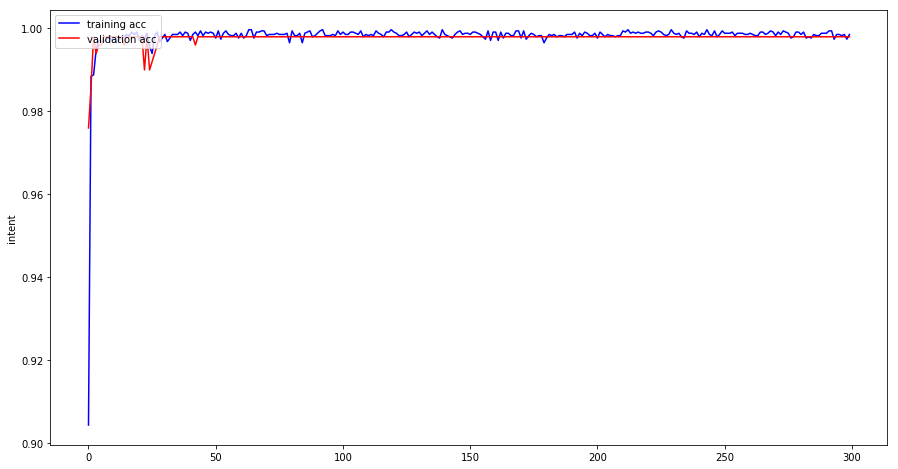

In [10]:
visualize_loss(op[2], op[3], _label="training acc", _label2="validation acc", _name="intent")

In [11]:
# Get test accuracy
assert('test_X' in _dataset.keys())

y_pred, _ = classifier.predict({'ques_batch': _dataset['test_X'], 'y_label':_dataset['test_Y']}, device=device, loss_fn=loss_fn)
classifier.eval(y_true=_dataset['test_Y'], y_pred=y_pred)

0.994